# Creating an Emoji-Leaderboard from you Messenger Traffic
This notebook takes a processed version of all the Facebook messages you have ever sent and received, and sets up a leaderboard with the most frequent emojis you have sent and received.

Let's start by importing a few awesome python libraries to help speed things up a bit as well as by defining a few variables to be used throughout the notebook.

In [8]:
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [9]:
# define the fonts and colors to use for plots
family = 'Helvetica'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')
bar_edge_color = '#272727'
yellow = '#FFE400'
green = '#14A76C'
orange = '#FF652F'

# Loading source data
At this point the raw Facebook data has already got ran through a fully privacy-friendly script which on the one hand kept all your secrets lying within your chats intact, and on the other hand it produced a csv file with which it will be quick and convenient to work with.

In [10]:
# load the messages csv data file
data = pd.read_csv('../resources/messages.csv')
# load the emoji data csv file
emoji_table = pd.read_csv('../resources/emoji-data-table.csv')

# extract emojis
all_emoji_strings = [*filter(lambda emoji : type(emoji) is str, data['emojis'])]
# convert strings to character lists
all_emojis_2d = [*map(lambda emoji_string : list(emoji_string), all_emoji_strings)]
# flatten 2d list
all_emojis = [item for sublist in all_emojis_2d for item in sublist]

In [11]:
# this many emojis will be ranked on the bar chart
emojis_to_rank = 10
emoji_counts = pd.Series(all_emojis).value_counts().sort_values(ascending=False)
emoji_counts[:emojis_to_rank]

😂    19860
❤     5369
😁     1959
😍     1687
😘     1363
😄      968
💋      728
😊      604
😭      505
✋      500
dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128139 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128139 missing from current font.
  font.set_text(s, 0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9995 missing from current font.
  font.set_text(s, 0, flags=flags)


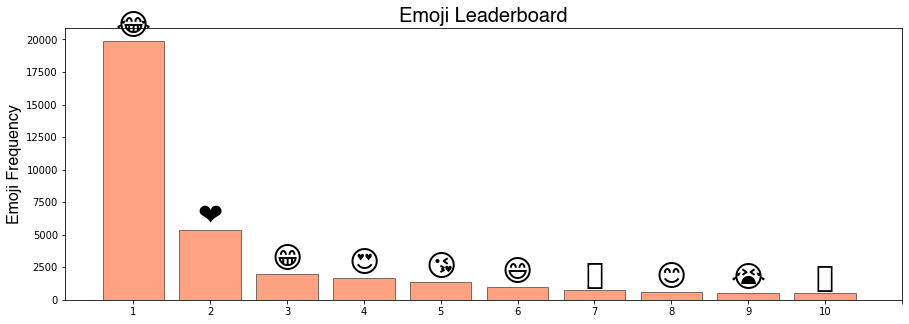

In [12]:
# Get data to be visualized
freqs = emoji_counts[:emojis_to_rank].values
emoji_labels = emoji_counts[:emojis_to_rank].index
fig = plt.figure(figsize=(15,5))
p1 = plt.bar(np.arange(len(emoji_labels)), freqs, 0.8, alpha=0.6, color=orange, edgecolor=bar_edge_color)
plt.ylim(0, plt.ylim()[1]+30)

# Set axis titles
ax = fig.axes[0]
ax.set_title('Emoji Leaderboard', fontproperties=title_font)
ax.set_xlabel('')
ax.set_ylabel('Emoji Frequency', fontproperties=label_font)

# Add emojis to the top of the bars as labels
for rect1, label in zip(p1, emoji_labels):
    height = rect1.get_height()
    plt.annotate(
        label,
        (rect1.get_x() + rect1.get_width()/2, height+5),
        ha="center",
        va="bottom",
        fontsize=30
    )

# set xlabels
plt.xticks(*[range(0, emojis_to_rank+1)], *[range(1, emojis_to_rank+1)])
plt.show()

##  Nice, isn't it?
Well... not really.

As the diagram above shows, plotting emojis using matplotlib is not so trivial as one might think. Emojis are specially encoded unicode characters and only the most popular ones are included in common fonts, hence we need a workaround.

Instead of adding them as labels as regular characters on one of the axes, they will be presented using image files. However, to do so, we need a mapping between an emoji and a corresponding url from which the correct image file can be requested using an http GET request.

Let's create some functions to facilitate this process:

In [13]:
# returns the 'url' column from the emoji_table csv of the specified emoji
def get_emoji_img_url(emoji):
    for i in range(len(emoji_table)): 
        if emoji_table.values[i][0] == emoji:
            return emoji_table.values[i][4]

# returns an actual image object for the specified emoji with a given size
# if no image url is found '❓' gets returned as an image
def get_emoji_img(emoji, size=32):
    url = get_emoji_img_url(emoji)
    url = url if type(url) == str else get_emoji_img_url('❓')
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.thumbnail((size, size), Image.ANTIALIAS)
    return img

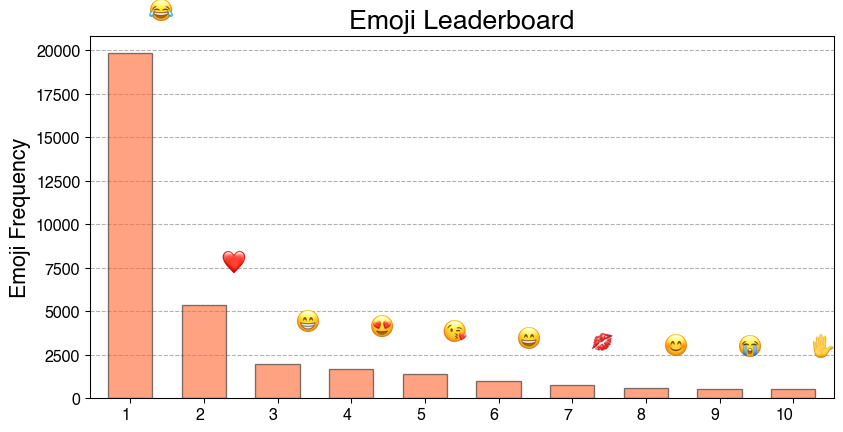

In [14]:
fig = plt.figure(figsize=[10, 5], dpi=96)
ax = emoji_counts[:emojis_to_rank].plot(kind='bar', width=0.6, alpha=0.6, color=orange, edgecolor=bar_edge_color, zorder=2)

xlabels = [*range(1, emojis_to_rank+1)]
ax.yaxis.grid(True, linestyle='--')
ax.set_xticklabels(xlabels, rotation=0, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Emoji Leaderboard', fontproperties=title_font)
ax.set_xlabel('')
ax.set_ylabel('Emoji Frequency', fontproperties=label_font)
    
bars = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]

for i in range(0, len(bars)-1):
    bar = bars[i]
    data_bbox = bar.get_bbox()
    display_bbox = data_bbox.transformed(ax.transData)
    img = get_emoji_img(emoji_counts.index[i], 24)
    bar_center_x = (display_bbox.x0 + display_bbox.x1) / 2
    img_x = bar_center_x - img.width / 2
    img_y = display_bbox.y1 + 5
    fig.figimage(img, img_x, img_y)

fig.savefig('images/messenger-emoji-leaderboard.png', dpi=96)
plt.show()

## A bit nicer, isn't it?
This diagram should look significantly better, since the emojis should appear as image files. However, their alignment on the top of the bars is far from perfect, when running the code inside a jupyter-notebook kernel, however, interestingly, when saved to an image file, this issue disappears, and the output file looks just as it should. (Don't take my word on it, just try it please)

But still...it is fair to say that this project achieved its goals, since we used the private data that Facebook collected about us to make some fun diagrams to gain insight about our chat traffic and emoji-preferences.